In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import get_data
import statsmodels
from simulate import cholesky
from simulate import simulatedata
from simulate import simulate_multiple_time_series

In [27]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
syms = ['BTCUSDT']
freq = '10min'
start_date = '2020-01-01'
end_date = '2020-01-03'

In [29]:
raw_data = get_data.get_data(syms, freq, start_date, end_date)
raw_data

BTCUSDT_2019-12-26.json
BTCUSDT_2020-01-02.json


e:\trade\crypto\Binance\get_data.py:52: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  data[symbol] = _fit_data_to_df(data[symbol], frequency)[start_time:end_time]


{'BTCUSDT':                               open     high      low    close      volume  \
 time                                                                        
 2020-01-01 00:00:00+00:00  7195.24  7196.25  7178.20  7191.07  154.874358   
 2020-01-01 00:10:00+00:00  7193.15  7193.53  7177.35  7178.29   80.261439   
 2020-01-01 00:20:00+00:00  7177.71  7185.56  7175.47  7178.45   96.049725   
 2020-01-01 00:30:00+00:00  7178.19  7185.44  7176.23  7177.53   59.973326   
 2020-01-01 00:40:00+00:00  7177.14  7182.99  7176.34  7182.94   44.872982   
 ...                            ...      ...      ...      ...         ...   
 2020-01-02 23:20:00+00:00  6959.16  6962.39  6950.00  6962.34  217.262815   
 2020-01-02 23:30:00+00:00  6962.47  6974.75  6957.66  6965.37  145.757951   
 2020-01-02 23:40:00+00:00  6965.09  6969.46  6959.87  6967.41   75.157310   
 2020-01-02 23:50:00+00:00  6967.40  6968.82  6961.24  6965.71   82.459841   
 2020-01-03 00:00:00+00:00  6965.49  6965.71  6948.45

In [30]:
dt = pd.DataFrame()
dt['close'] = raw_data['BTCUSDT']['close']
dt['high'] = raw_data['BTCUSDT']['high']
dt['low'] = raw_data['BTCUSDT']['low']
dt['open'] = raw_data['BTCUSDT']['open']
dt['close-open'] = raw_data['BTCUSDT']['close']/raw_data['BTCUSDT']['open']
dt.iloc[150]

close         7202.090000
high          7211.160000
low           7201.580000
open          7211.040000
close-open       0.998759
Name: 2020-01-02 01:00:00+00:00, dtype: float64

In [7]:
dt1 = pd.DataFrame()
dt1['open'] = dt['open'].pct_change()
dt1['close'] = dt['close-open'].pct_change()
dt1

,open,close
time,,
2020-01-01 00:00:00+00:00,NaN,NaN
2020-01-01 00:10:00+00:00,-0.000290,-0.001487
2020-01-01 00:20:00+00:00,-0.002146,0.002173
2020-01-01 00:30:00+00:00,0.000067,-0.000195
2020-01-01 00:40:00+00:00,-0.000146,0.000900
...,...,...
2020-01-02 23:20:00+00:00,-0.001664,0.002125
2020-01-02 23:30:00+00:00,0.000476,-0.000040
2020-01-02 23:40:00+00:00,0.000376,-0.000083


In [8]:
var_close = simulate_multiple_time_series.compute_std(dt1['close'])
mean_close = dt1['close'].mean()
var_open = simulate_multiple_time_series.compute_std(dt1['open'])
mean_open = dt1['open'].mean()
chol = cholesky.cholesky2(dt)
inverse_chol = np.linalg.inv(chol)
transform= simulate_multiple_time_series.transform_forward(dt1, inverse_chol)
transform

,open,close
time,,
2020-01-01 00:00:00+00:00,NaN,NaN
2020-01-01 00:10:00+00:00,-0.127426,-0.730574
2020-01-01 00:20:00+00:00,-1.450286,0.911047
2020-01-01 00:30:00+00:00,0.127268,-0.083660
2020-01-01 00:40:00+00:00,-0.024653,0.430266
...,...,...
2020-01-02 23:20:00+00:00,-1.106465,0.919618
2020-01-02 23:30:00+00:00,0.418607,0.018125
2020-01-02 23:40:00+00:00,0.347811,-0.009218


In [10]:
order_close, seasonal_order_close = simulatedata.get_order(transform['close'][1:])
order_open, seasonal_order_open = simulatedata.get_order(transform['open'][1:])
order_close, seasonal_order_close, order_open, seasonal_order_open

((1, 0, 2), (0, 0, 0, 1), (2, 0, 0), (0, 0, 0, 1))

In [11]:
if sum(seasonal_order_close) == 1: seasonal_order_close = (0, 0, 0, 0)
model_params_close = simulatedata.fit_sarima(transform['close'][1:], order_close, seasonal_order_close)
if sum(seasonal_order_open) == 1: seasonal_order_open = (0, 0, 0, 0)
model_params_open = simulatedata.fit_sarima(transform['open'][1:], order_open, seasonal_order_open)

In [12]:
t_close = simulatedata.simulate_sarima(transform['close'][1:], order_close, seasonal_order_close, model_params_close, len(dt1), 1)
t_open = simulatedata.simulate_sarima(transform['open'][1:], order_open, seasonal_order_open, model_params_open, len(dt1), 1)
t_open

,0
0,0.440205
1,-0.562573
2,0.552087
3,-0.026885
4,1.534314
...,...
284,-0.143524
285,1.532714
286,-0.698809
287,-0.045988


In [13]:
transform_x_chol = pd.DataFrame()
transform_x_chol['close'] = t_close[0]
transform_x_chol['open'] = t_open[0]
transform_back = simulate_multiple_time_series.transform_back(transform_x_chol, chol, var_close, mean_close, var_open, mean_open)
transform_back

,open,close
0,0.000506,0.000541
1,-0.000901,0.000375
2,0.000663,-0.000515
3,-0.000149,-0.002046
4,0.002041,0.000348
...,...,...
284,-0.000313,-0.000933
285,0.002039,-0.000014
286,-0.001092,0.001229
287,-0.000176,0.001008


In [14]:
transform_back.corr()

,open,close
open,1.000000,-0.118275
close,-0.118275,1.000000


In [15]:
dt1.corr()

,open,close
open,1.00000,-0.73857
close,-0.73857,1.00000


In [17]:
simulated_price_data = pd.DataFrame()
simulated_price_data[0] = simulatedata.construct_price_series(transform_back['open'], dt['open'][0], dt.index[0], freq)
simulated_price_data[1] = simulatedata.construct_price_series(transform_back['close'], dt['close-open'][0], dt.index[0], freq)
for i in range(len(simulated_price_data[1])):
    simulated_price_data[1][i]=simulated_price_data[1][i] * simulated_price_data[0][i]
simulated_price_data

,0,1
2020-01-01 00:00:00+00:00,7195.240000,7191.070000
2020-01-01 00:10:00+00:00,7198.880326,7198.599945
2020-01-01 00:20:00+00:00,7192.394166,7194.810524
2020-01-01 00:30:00+00:00,7197.162069,7195.873630
2020-01-01 00:40:00+00:00,7196.086758,7180.080219
...,...,...
2020-01-02 23:20:00+00:00,6957.657726,6956.771191
2020-01-02 23:30:00+00:00,6955.479592,6948.103301
2020-01-02 23:40:00+00:00,6969.660157,6962.172982
2020-01-02 23:50:00+00:00,6962.048322,6963.119596


C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by sett

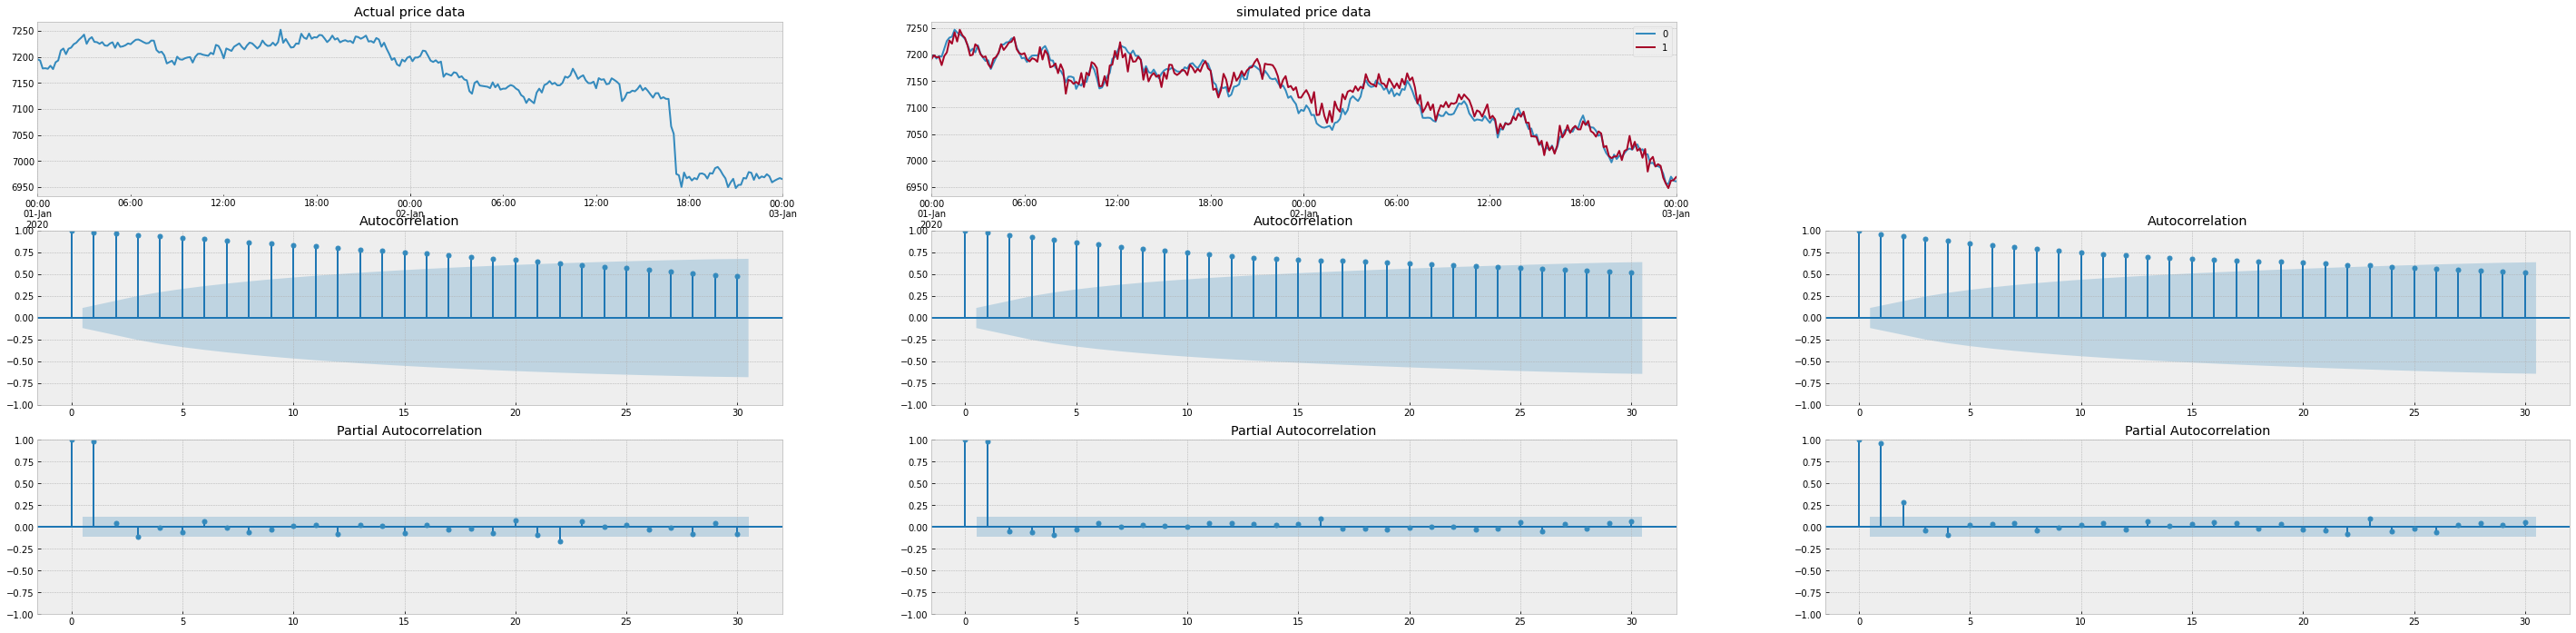

In [19]:
simulatedata.Evaluate_performance(dt['open'], simulated_price_data, lags=30)

In [33]:
simulate_multiple_time_series.simulate_open_and_close(dt)

,close,open
2020-01-01 00:00:00+00:00,7191.070000,7195.240000
2020-01-01 00:00:00.000000001+00:00,7192.708302,7206.530454
2020-01-01 00:00:00.000000002+00:00,7192.979230,7216.448455
2020-01-01 00:00:00.000000003+00:00,7185.405129,7193.224678
2020-01-01 00:00:00.000000004+00:00,7182.624146,7208.809476
...,...,...
2020-01-01 00:00:00.000000284+00:00,6960.902873,7118.380847
2020-01-01 00:00:00.000000285+00:00,6958.300299,7107.526377
2020-01-01 00:00:00.000000286+00:00,6963.975954,7102.370383
2020-01-01 00:00:00.000000287+00:00,6974.528193,7098.196459


In [ ]:
# order, seasonal_order = simulatedata.get_order(dt['open'][1:])
# order, seasonal_order

In [ ]:
# if sum(seasonal_order) == 1: seasonal_order = (0, 0, 0, 0)
# model_params = simulatedata.fit_sarima(dt['open'][1:], order, seasonal_order)

In [ ]:
# t = simulatedata.simulate_sarima(dt['open'][1:], order, seasonal_order, model_params, len(dt), 10)
# t

In [ ]:
# simulated_price_data = simulatedata.construct_price_series(t, dt['close'][0], dt.index[0], freq)

In [ ]:
# simulatedata.Evaluate_performance(dt['close'], simulated_price_data, lags=30)